# Getting Started with Sentiment Analysis on Twitter

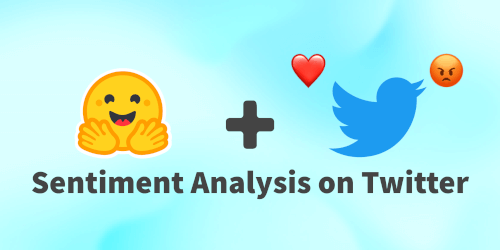

## 1. Install dependencies

In [ ]:
!pip install -q tweepy matplotlib wordcloud

## 2. Set up Twitter API credentials





In [ ]:
import tweepy

# Add Twitter API key and secret
consumer_key = "XXXXX"
consumer_secret = "XXXXX"

# Handling authentication with Twitter
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)

# Create a wrapper for the Twitter API
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

## *3. Search for tweets using Tweepy*

In [ ]:
# Helper function for handling pagination in our search and handle rate limits
def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            print('Reached rate limite. Sleeping for >15 minutes')
            time.sleep(15 * 61)
        except StopIteration:
            break

# Define the term we will be using for searching tweets
query = '@notionhq'
query = query + ' -filter:retweets'

# Define how many tweets to get from the Twitter API 
count = 1000

# Search for tweets using Tweepy 
search = limit_handled(tweepy.Cursor(api.search,
                        q=query,
                        tweet_mode='extended',
                        lang='en',
                        result_type="recent").items(count))

# Process the results from the search using Tweepy
tweets = []
for result in search:
    tweet_content = result.full_text
    # Only saving the tweet content. 
    # You could also save other attributes for each tweet like date or # of RTs.
    tweets.append(tweet_content)

## 4. Run sentiment analysis on the tweets

In [ ]:
import requests
import time

# Set up the API call to the Inference API to do sentiment analysis
model = "cardiffnlp/twitter-roberta-base-sentiment-latest"
hf_token = "XXXXX"
API_URL = "https://api-inference.huggingface.co/models/" + model
headers = {"Authorization": "Bearer %s" % (hf_token)}

def analysis(data):
    payload = dict(inputs=data, options=dict(wait_for_model=True))
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

# Let's run the sentiment analysis on each tweet
tweets_analysis = []
for tweet in tweets:
    try:
        sentiment_result = analysis(tweet)[0]
        top_sentiment = max(sentiment_result, key=lambda x: x['score']) # Get the sentiment with the higher score     
        tweets_analysis.append({'tweet': tweet, 'sentiment': top_sentiment['label']})

    except Exception as e: 
        print(e)

## 5.Explore the results of sentiment analysis

In [ ]:
import pandas as pd

# Load the data in a dataframe
pd.set_option('max_colwidth', None)
pd.set_option('display.width', 3000) 
df = pd.DataFrame(tweets_analysis)

# Show a tweet for each sentiment 
display(df[df["sentiment"] == 'Positive'].head(1))
display(df[df["sentiment"] == 'Neutral'].head(1))
display(df[df["sentiment"] == 'Negative'].head(1))

,tweet,sentiment
0,"@jameygannon @NotionHQ A regression imo, I think it’s great to have both the previous way and current way implemented if done right. Because the new way has benefits, there’s just way more friction to get there.",Positive


,tweet,sentiment
3,@FlowRadarcom @TemplarDesign @mmduarte @airtable @RowsHQ @NotionHQ @coda_hq @softr_io @webflow @AdaloHQ @glideapps @bubble @WordPress Database limitation is the red glad holding me back from going full scale with WF,Neutral


,tweet,sentiment
4,@TemplarDesign @FlowRadarcom @mmduarte @airtable @RowsHQ @NotionHQ @coda_hq @softr_io @webflow @AdaloHQ @glideapps @bubble @WordPress Webflow hasn’t yet rob off me because of the CMS database limitations. Not enough- can’t scale with that,Negative


sentiment
Negative     21
Neutral     121
Positive    158
dtype: int64


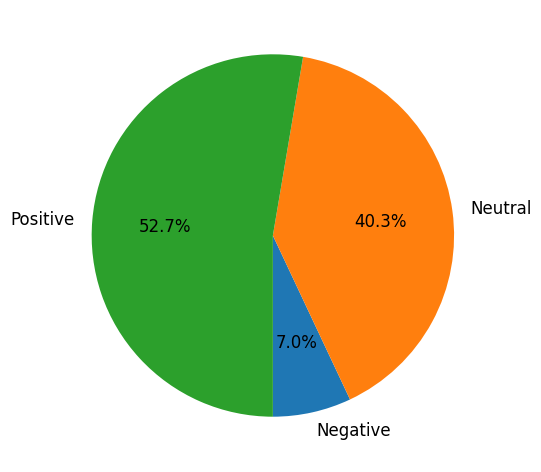

In [ ]:
import matplotlib.pyplot as plt

# Let's count the number of tweets by sentiments
sentiment_counts = df.groupby(['sentiment']).size()
print(sentiment_counts)

# Let's visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

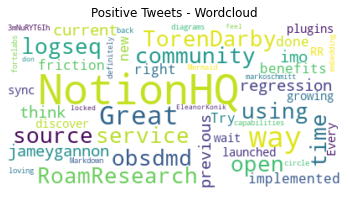

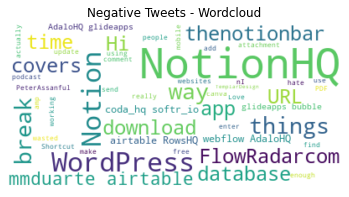

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# Wordcloud with positive tweets
positive_tweets = df['tweet'][df["sentiment"] == 'Positive']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud with negative tweets
negative_tweets = df['tweet'][df["sentiment"] == 'Negative']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()